In [1]:
#import packages and functions

%load_ext autoreload
%autoreload 2

import pursuit_functions as pursuit
    
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
#load data set

all_pursuit_tasks = pd.read_parquet("ca1_ca3_rsc_pursuit_data.parquet", engine="pyarrow")

# Normalize points and find circle boundaries.

In [42]:
#get all coordinate values below 99th percentile and normalize points for all regions 

normalized_sessions = pursuit.tuning.normalize_points(all_pursuit_tasks)

In [ ]:
normalized_sessions.head()

In [43]:
#find the mean center and overall radius of the arena for all normalized data points
#you can specify the percentile value to be considered for the overall radius; default is 95th percentile
#calculates the individual center point for each session

circle_boundaries, radius = pursuit.tuning.fit_circle_bounds(normalized_sessions)
print(radius)

61.179933135984626


In [ ]:
circle_boundaries.head()

In [44]:
#find circumference points for plotting using the center coordinates and overall radius
all_circ_points = pursuit.tuning.circumference(circle_boundaries)

# Plot the laser coordinates and boundaries.

In [ ]:
#plot normalized concatenated laser and rat paths with center point and boundary
#the function takes the normalized_sessions, circle_boundaries, and all_circ_points dataframes

pursuit.tuning.plot_arena_bounds(normalized_sessions, circle_boundaries, all_circ_points)

# Clean data and pull spike data.

In [ ]:
# obtain region-specific sessions
RSC_sessions = all_pursuit_tasks[all_pursuit_tasks["region"] == "RSC"]
CA1_sessions = all_pursuit_tasks[all_pursuit_tasks["region"] == "CA1"]
CA3_sessions = all_pursuit_tasks[all_pursuit_tasks["region"] == "CA3"]



In [24]:
#obtain trial block-specific sessions

RSC_pursuit = RSC_sessions[RSC_sessions["trial_block"] == "pursuit"]
CA1_pursuit = CA1_sessions[CA1_sessions["trial_block"] == "pursuit"]
CA3_pursuit = CA3_sessions[CA3_sessions["trial_block"] == "pursuit"]

In [30]:
#drop NA values for RSC, CA1, and CA3 sessions

RSC_cleaned = pursuit.tuning.drop_NA_vals(RSC_pursuit)
CA1_cleaned = pursuit.tuning.drop_NA_vals(CA1_pursuit)
CA3_cleaned = pursuit.tuning.drop_NA_vals(CA3_pursuit)

In [31]:
def normalize_time(dataframe):
    df = dataframe.copy()
    df["time"] = df["time"].astype(float)
    df["relative_time"] = df.groupby("sessFile")["time"].transform(lambda x: x - x.min())
    df["norm_sec"] = df["relative_time"].astype(int)
    df["norm_min"] = df["norm_sec"] // 60

    return df


In [32]:
RSC_clean_time = normalize_time(RSC_cleaned)

In [33]:
RSC_clean_time

,time,ind,ratPos_1,ratPos_2,laserPos_1,laserPos_2,ratVel,ratAcc,laserVel,laserAcc,...,spkTable_31,spkTable_32,spkTable_33,spkTable_34,region,trial_block,sessFile,relative_time,norm_sec,norm_min
7080778,138.625,8321,161.75,90.0625,146.0,76.3125,43.375,60.8125,36.46875,79.1875,...,<NA>,<NA>,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.000,0,0
7080779,138.750,8322,161.25,89.4375,145.5,76.125,44.40625,59.09375,37.78125,78.625,...,<NA>,<NA>,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.125,0,0
7080780,138.750,8323,160.75,88.6875,145.0,76.0625,45.375,57.46875,39.09375,78.1875,...,<NA>,<NA>,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.125,0,0
7080781,138.750,8324,160.25,88.0,144.5,75.9375,46.3125,56.125,40.40625,77.8125,...,<NA>,<NA>,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.125,0,0
7080782,138.750,8325,159.875,87.25,144.0,75.8125,47.1875,55.0625,41.6875,77.4375,...,<NA>,<NA>,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.125,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49368102,2172.000,130295,91.6875,111.4375,99.6875,118.625,67.125,89.8125,25.296875,586.5,...,<NA>,<NA>,<NA>,<NA>,RSC,pursuit,LP06_29_pursuitRoot.mat,1478.500,1478,24
49368103,2172.000,130296,91.9375,112.5,99.625,119.125,66.3125,88.8125,25.015625,652.0,...,<NA>,<NA>,<NA>,<NA>,RSC,pursuit,LP06_29_pursuitRoot.mat,1478.500,1478,24
49368104,2172.000,130297,92.25,113.625,99.5,119.75,65.4375,87.9375,28.859375,721.0,...,<NA>,<NA>,<NA>,<NA>,RSC,pursuit,LP06_29_pursuitRoot.mat,1478.500,1478,24
49368105,2172.000,130298,92.5625,114.6875,99.25,120.6875,64.5,87.3125,36.59375,791.5,...,<NA>,<NA>,<NA>,<NA>,RSC,pursuit,LP06_29_pursuitRoot.mat,1478.500,1478,24


In [35]:
def assign_epochs(dataframe):
    df = dataframe.copy()

    # separate epochs by half

    def label_half(group):
        mins = group["norm_min"].unique()
        mins.sort()
        cutoff = mins[len(mins) // 2]
        return group["norm_min"] <= cutoff
    
    df["epoch_half"] = df.groupby("sessFile", group_keys=False).apply(label_half).map({True: 1, False:2})

    # separate epochs by odd/even minutes

    df["epoch_odd_even"] = df["norm_min"] % 2
    df["epoch_odd_even"] = df["epoch_odd_even"].map({1: 1, 0: 2})

    return df


In [36]:
# for epoch_half, True:1, False:2 will result in the first half labeled as 1 (<= cutoff) and the second half labeled as 2
# for epoch_odd_even, we take the minutes divided by 2 and find the remainder. If the remainder is 1 (odd), it will be labeled as 1 and if the remainder is 0 (even), it will be labeled as 2
RSC_clean_time_epochs = assign_epochs(RSC_clean_time)

RSC_clean_time_epochs

/var/folders/k4/zr04khhn74zcj29mf4f0v8hc0000gn/T/ipykernel_62893/1331361621.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["epoch_half"] = df.groupby("sessFile", group_keys=False).apply(label_half).map({True: 1, False:2})


,time,ind,ratPos_1,ratPos_2,laserPos_1,laserPos_2,ratVel,ratAcc,laserVel,laserAcc,...,spkTable_33,spkTable_34,region,trial_block,sessFile,relative_time,norm_sec,norm_min,epoch_half,epoch_odd_even
7080778,138.625,8321,161.75,90.0625,146.0,76.3125,43.375,60.8125,36.46875,79.1875,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.000,0,0,1,2
7080779,138.750,8322,161.25,89.4375,145.5,76.125,44.40625,59.09375,37.78125,78.625,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.125,0,0,1,2
7080780,138.750,8323,160.75,88.6875,145.0,76.0625,45.375,57.46875,39.09375,78.1875,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.125,0,0,1,2
7080781,138.750,8324,160.25,88.0,144.5,75.9375,46.3125,56.125,40.40625,77.8125,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.125,0,0,1,2
7080782,138.750,8325,159.875,87.25,144.0,75.8125,47.1875,55.0625,41.6875,77.4375,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.125,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49368102,2172.000,130295,91.6875,111.4375,99.6875,118.625,67.125,89.8125,25.296875,586.5,...,<NA>,<NA>,RSC,pursuit,LP06_29_pursuitRoot.mat,1478.500,1478,24,2,2
49368103,2172.000,130296,91.9375,112.5,99.625,119.125,66.3125,88.8125,25.015625,652.0,...,<NA>,<NA>,RSC,pursuit,LP06_29_pursuitRoot.mat,1478.500,1478,24,2,2
49368104,2172.000,130297,92.25,113.625,99.5,119.75,65.4375,87.9375,28.859375,721.0,...,<NA>,<NA>,RSC,pursuit,LP06_29_pursuitRoot.mat,1478.500,1478,24,2,2
49368105,2172.000,130298,92.5625,114.6875,99.25,120.6875,64.5,87.3125,36.59375,791.5,...,<NA>,<NA>,RSC,pursuit,LP06_29_pursuitRoot.mat,1478.500,1478,24,2,2


In [37]:
RSC_clean_time_epochs[RSC_clean_time_epochs["sessFile"] == "KB10_02_pursuitRoot.mat"]

,time,ind,ratPos_1,ratPos_2,laserPos_1,laserPos_2,ratVel,ratAcc,laserVel,laserAcc,...,spkTable_33,spkTable_34,region,trial_block,sessFile,relative_time,norm_sec,norm_min,epoch_half,epoch_odd_even
7080778,138.625,8321,161.75,90.0625,146.0,76.3125,43.375,60.8125,36.46875,79.1875,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.000,0,0,1,2
7080779,138.750,8322,161.25,89.4375,145.5,76.125,44.40625,59.09375,37.78125,78.625,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.125,0,0,1,2
7080780,138.750,8323,160.75,88.6875,145.0,76.0625,45.375,57.46875,39.09375,78.1875,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.125,0,0,1,2
7080781,138.750,8324,160.25,88.0,144.5,75.9375,46.3125,56.125,40.40625,77.8125,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.125,0,0,1,2
7080782,138.750,8325,159.875,87.25,144.0,75.8125,47.1875,55.0625,41.6875,77.4375,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,0.125,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7236353,1435.000,86106,109.6875,119.125,106.5625,124.5625,56.625,110.6875,245.625,1406.0,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,1296.375,1296,21,2,1
7236354,1435.000,86107,109.625,120.125,106.8125,125.3125,54.8125,116.625,269.75,1385.0,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,1296.375,1296,21,2,1
7236355,1435.000,86108,109.5625,121.0625,107.0625,126.125,52.9375,122.375,293.75,1339.0,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,1296.375,1296,21,2,1
7236356,1435.000,86109,109.4375,121.9375,107.3125,126.875,50.96875,127.9375,317.0,1265.0,...,<NA>,<NA>,RSC,pursuit,KB10_02_pursuitRoot.mat,1296.375,1296,21,2,1


In [ ]:
function for pulling 1's and 2's 

# mapping first half and second epochs for each session 

1 first 
2 second

# mapping odd and even epochs for each session
1 odd
2 even 

In [ ]:
new dfs needed

def epoch_laser_spks(dataframe, laser_x="laserPos_1", laser_y="laserPos_2"):

    epoch_laser_spks_data = []

    spk_columns = [col for col in dataframe.columns if "spkTable" in col]
    
    for sessFile in dataframe["sessFile"].unique():

            session = dataframe[dataframe["sessFile"] == sessFile].copy()

            laser_x_vals = session[laser_x].astype("float64")
            laser_y_vals = session[laser_y].astype("float64")
    
            #identify 99th percentile x, y boundaries
            x_low, x_high = np.percentile(laser_x_vals, [0, 99])
            y_low, y_high = np.percentile(laser_y_vals, [0, 99])

            #filter the data so we only get the data under the 99th percentile
            filter = (
                (laser_x_vals >= x_low) & (laser_x_vals <= x_high) & 
                (laser_y_vals >= y_low) & (laser_y_vals <= y_high)
            )

            filtered_session = session[filter].copy()

            #normalize the points to the origin
            x_normalized = filtered_session[laser_x].astype("float64") - float(x_low)
            y_normalized = filtered_session[laser_y].astype("float64") - float(y_low)

            #grab epoch data 
            epoch_half = filtered_session["epoch_half"].values
            epoch_odd_even = filtered_session["epoch_odd_even"].values

            #make a dataframe containing normalized data
            normalized_df = pd.DataFrame({
                "sessFile": sessFile,
                "laser_x_normalized": x_normalized.values,
                "laser_y_normalized": y_normalized.values,
                "epoch_half": epoch_half,
                "epoch_odd_even": epoch_odd_even
            })

            #grab spike data using the normalized data mask
            spk_df = filtered_session[spk_columns].reset_index(drop=True)

            #make a combined dataframe
            combined_df = pd.concat([normalized_df.reset_index(drop=True), spk_df], axis=1)

            #append dataframe to the list
            epoch_laser_spks_data.append(combined_df)

        #make a giant dataframe by concatenating all the dataframes in the list        
    epoch_laser_spks_df = pd.concat(epoch_laser_spks_data, ignore_index=True)

    return epoch_laser_spks_df

IndentationError: unindent does not match any outer indentation level (<string>, line 64)

In [14]:
def unique_time_entries(dataframe):
    all_sessions = []

    for sessFile in dataframe["sessFile"].unique():
        session = dataframe[dataframe["sessFile"] == sessFile]
        session_times = session["time"]

        times_unique = session_times.astype("float64").nunique()
        times_count = session_times.astype("float64").value_counts().to_dict()

        all_sessions.append({
            "sessFile": sessFile,
            "times_unique": times_unique,
            "unique_times_count": times_count
        })

    return pd.DataFrame(all_sessions)

In [16]:
RSC_sessions_times = unique_time_entries(RSC_sessions)
RSC_sessions_times

,sessFile,times_unique,unique_times_count
0,KB10_02_pursuitRoot.mat,4155,"{2066.0: 240, 2278.0: 240, 2282.0: 240, 2284.0..."
1,KB10_03_pursuitRoot.mat,4491,"{2280.0: 120, 2234.0: 120, 2238.0: 120, 2240.0..."
2,KB10_08_pursuitRoot.mat,5419,"{2114.0: 120, 2152.0: 120, 2130.0: 120, 2132.0..."
3,KB10_09_pursuitRoot.mat,4788,"{2602.0: 360, 2356.0: 360, 2642.0: 360, 2644.0..."
4,KB10_10_pursuitRoot.mat,5213,"{2676.0: 600, 2372.0: 600, 2376.0: 600, 2378.0..."
5,KB10_11_pursuitRoot.mat,4830,"{3006.0: 480, 2834.0: 480, 2838.0: 480, 2840.0..."
6,KB10_13_pursuitRoot.mat,4974,"{2340.0: 240, 2698.0: 240, 2492.0: 240, 2490.0..."
7,KB10_15_pursuitRoot.mat,5129,"{2832.0: 120, 2566.0: 120, 2400.0: 120, 2402.0..."
8,KB10_17_pursuitRoot.mat,5389,"{2574.0: 120, 2562.0: 120, 2546.0: 120, 2548.0..."
9,KB10_20_pursuitRoot.mat,5683,"{2208.0: 120, 2270.0: 120, 2236.0: 120, 2238.0..."


In [22]:
def inspect_time_counts(session_row):
    times= session_row["unique_times_count"]
    sorted_times = sorted(times.items())
    return pd.DataFrame(sorted_times, columns=["time", "count"])

In [26]:
lp03_25 = RSC_sessions_times[RSC_sessions_times["sessFile"] == "LP03_25_pursuitRoot.mat"]

lp03_25_row = lp03_25.iloc[0]

lp03_25_inspection = inspect_time_counts(lp03_25_row)


lp03_25_inspection

,time,count
0,19.671875,2
1,19.687500,2
2,19.703125,2
3,19.718750,2
4,19.734375,2
5,19.750000,2
6,19.765625,2
7,19.781250,2
8,19.796875,2
9,19.812500,2


In [8]:
RSC_cleaned.head(10)

,time,ind,ratPos_1,ratPos_2,laserPos_1,laserPos_2,ratVel,ratAcc,laserVel,laserAcc,...,spkTable_28,spkTable_29,spkTable_30,spkTable_31,spkTable_32,spkTable_33,spkTable_34,region,trial_block,sessFile
6968713,1480.0,88778,171.5,108.8125,174.625,109.4375,17.03125,48.1875,0.722656,343.25,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,RSC,FE1,KB10_02_pursuitRoot.mat
6969034,1485.0,89099,189.25,100.5625,192.375,99.1875,6.933594,29.21875,109.75,1887.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,RSC,FE1,KB10_02_pursuitRoot.mat
6969035,1485.0,89100,189.25,100.6875,192.75,99.1875,6.472656,31.59375,75.5,2074.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,RSC,FE1,KB10_02_pursuitRoot.mat
6969036,1485.0,89101,189.375,100.75,192.375,98.9375,5.980469,33.71875,37.71875,2172.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,RSC,FE1,KB10_02_pursuitRoot.mat
6969037,1485.0,89102,189.5,100.8125,192.125,98.9375,5.464844,35.59375,1.760742,2170.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,RSC,FE1,KB10_02_pursuitRoot.mat
6969038,1485.0,89103,189.5,100.875,192.125,98.9375,4.925781,37.1875,41.125,2074.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,RSC,FE1,KB10_02_pursuitRoot.mat
6969039,1485.0,89104,189.625,100.9375,191.875,98.75,4.378906,38.53125,78.5,1885.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,RSC,FE1,KB10_02_pursuitRoot.mat
6969040,1485.0,89105,189.625,101.0,191.875,98.75,3.828125,39.59375,112.0,1624.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,RSC,FE1,KB10_02_pursuitRoot.mat
6969150,1487.0,89215,182.625,100.9375,181.5,104.5,5.003906,25.109375,5.816406,697.5,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,RSC,FE1,KB10_02_pursuitRoot.mat
6969151,1487.0,89216,182.5,101.0,181.5,104.75,5.359375,24.96875,7.90625,666.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,RSC,FE1,KB10_02_pursuitRoot.mat


In [40]:
#normalize only laser points and make a dataframe containing spike data using the normalized data mask
#function takes the cleaned df
RSC_laser_spks = pursuit.tuning.norm_laser_get_spks(RSC_cleaned)
CA1_laser_spks = pursuit.tuning.norm_laser_get_spks(CA1_cleaned)
CA3_laser_spks = pursuit.tuning.norm_laser_get_spks(CA3_cleaned)

In [41]:
CA1_laser_spks.head(50)

,sessFile,laser_x_normalized,laser_y_normalized,spkTable_1,spkTable_2,spkTable_3,spkTable_4,spkTable_5,spkTable_6,spkTable_7,...,spkTable_25,spkTable_26,spkTable_27,spkTable_28,spkTable_29,spkTable_30,spkTable_31,spkTable_32,spkTable_33,spkTable_34
0,KB09_20_pursuitRoot.mat,74.250,91.7500,0,0,1,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,KB09_20_pursuitRoot.mat,74.250,91.1250,0,0,0,0,0,1,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,KB09_20_pursuitRoot.mat,74.250,90.6250,0,0,0,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,KB09_20_pursuitRoot.mat,74.250,90.1875,0,1,0,0,0,1,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,KB09_20_pursuitRoot.mat,74.375,89.7500,0,0,0,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,KB09_20_pursuitRoot.mat,74.375,89.2500,0,0,0,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,KB09_20_pursuitRoot.mat,74.500,88.8125,0,0,1,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7,KB09_20_pursuitRoot.mat,74.625,88.2500,0,0,1,0,0,1,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
8,KB09_20_pursuitRoot.mat,74.875,87.6875,0,0,2,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9,KB09_20_pursuitRoot.mat,75.125,87.1250,0,0,1,0,0,1,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


# Find distance of laser points to boundary and bin data by distance.

In [15]:
#find distance of normalized laser points to circle boundary by each session
#function takes the normalized laser/spikes and circle boundaries dataframes

RSC_laser_spks_bounds = pursuit.tuning.dist_to_bounds(RSC_laser_spks, circle_boundaries)
CA1_laser_spks_bounds = pursuit.tuning.dist_to_bounds(CA1_laser_spks, circle_boundaries)
CA3_laser_spks_bounds = pursuit.tuning.dist_to_bounds(CA3_laser_spks, circle_boundaries)

In [ ]:
CA3_laser_spks_bounds.head(50)

In [ ]:
#bin the data!
RSC_laser_spikes_binned = pursuit.tuning.bin_spikes_laser(RSC_laser_spks_bounds)
CA1_laser_spikes_binned = pursuit.tuning.bin_spikes_laser(CA1_laser_spks_bounds)
CA3_laser_spikes_binned = pursuit.tuning.bin_spikes_laser(CA3_laser_spks_bounds)

# Normalize spike counts, smooth data, peak sort neurons, and plot tuning curves.

In [ ]:
#calculate raw tuning curves
RSC_tuning = pursuit.tuning.calculate_tuning(RSC_laser_spikes_binned)
CA1_tuning = pursuit.tuning.calculate_tuning(CA1_laser_spikes_binned)
CA3_tuning = pursuit.tuning.calculate_tuning(CA3_laser_spikes_binned)

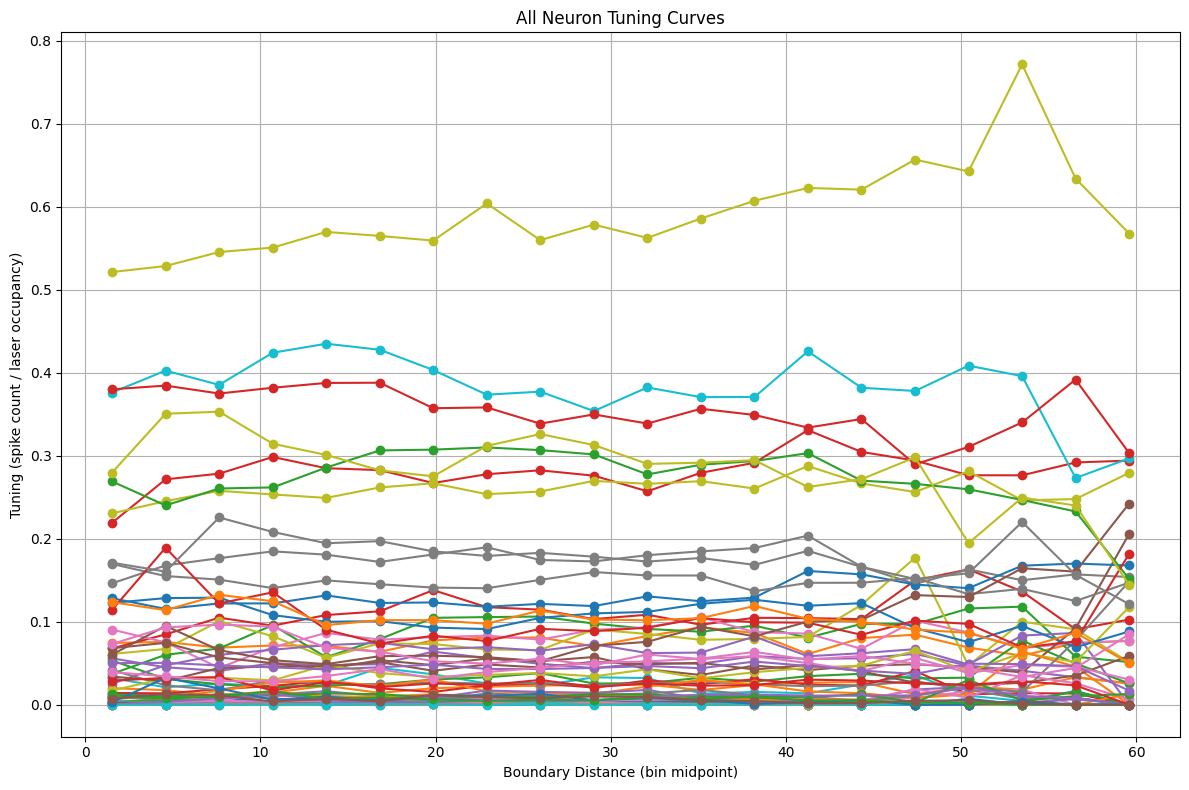

In [18]:
#plot all neuron tuning curves for a sanity check

pursuit.tuning.plot_tuning_curves(CA3_tuning)

In [ ]:
# z-score and normalize data
RSC_z_scored = pursuit.tuning.z_score_norm(RSC_tuning)
CA1_z_scored = pursuit.tuning.z_score_norm(CA1_tuning)
CA3_z_scored = pursuit.tuning.z_score_norm(CA3_tuning)

In [ ]:
# apply smoothing and pivot data
RSC_smoothed = pursuit.tuning.pivot_smooth(RSC_z_scored)
CA1_smoothed = pursuit.tuning.pivot_smooth(CA1_z_scored)
CA3_smoothed = pursuit.tuning.pivot_smooth(CA3_z_scored)

In [ ]:
# peak sort the data
RSC_smoothed_sorted = pursuit.tuning.peak_sort(RSC_smoothed)
CA1_smoothed_sorted = pursuit.tuning.peak_sort(CA1_smoothed)
CA3_smoothed_sorted = pursuit.tuning.peak_sort(CA3_smoothed)

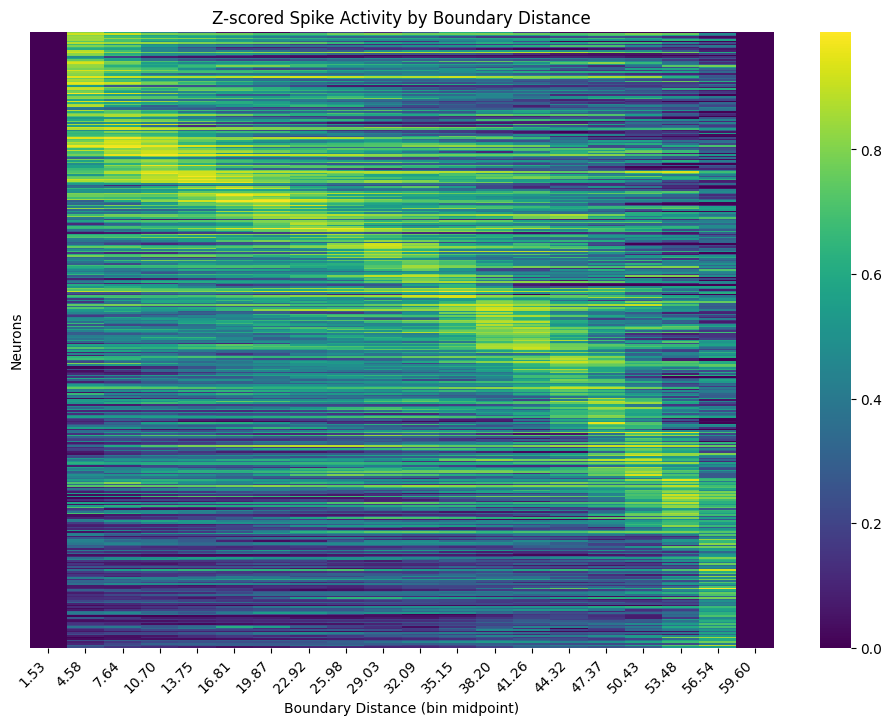

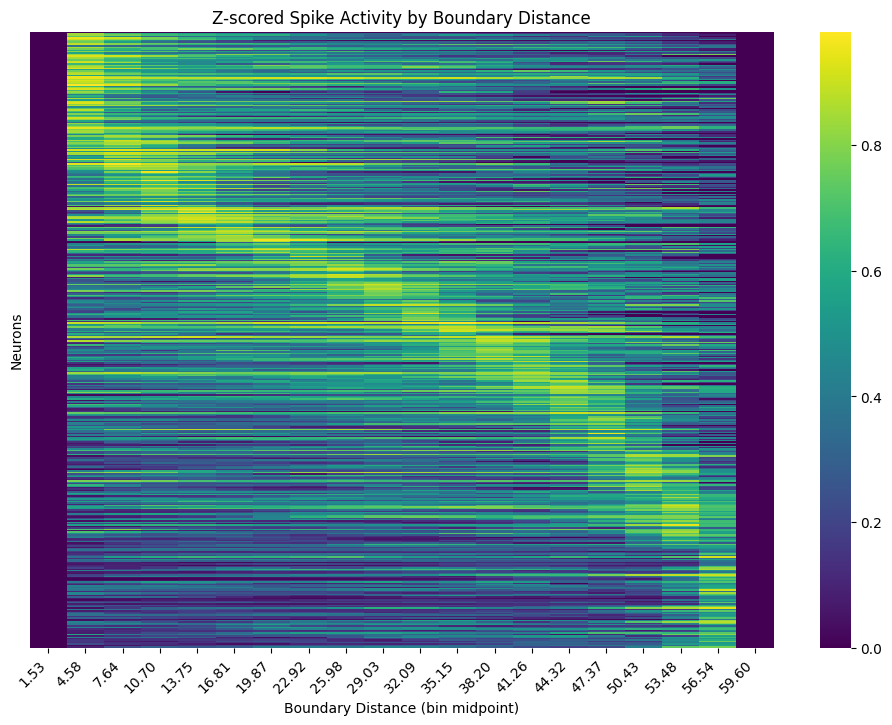

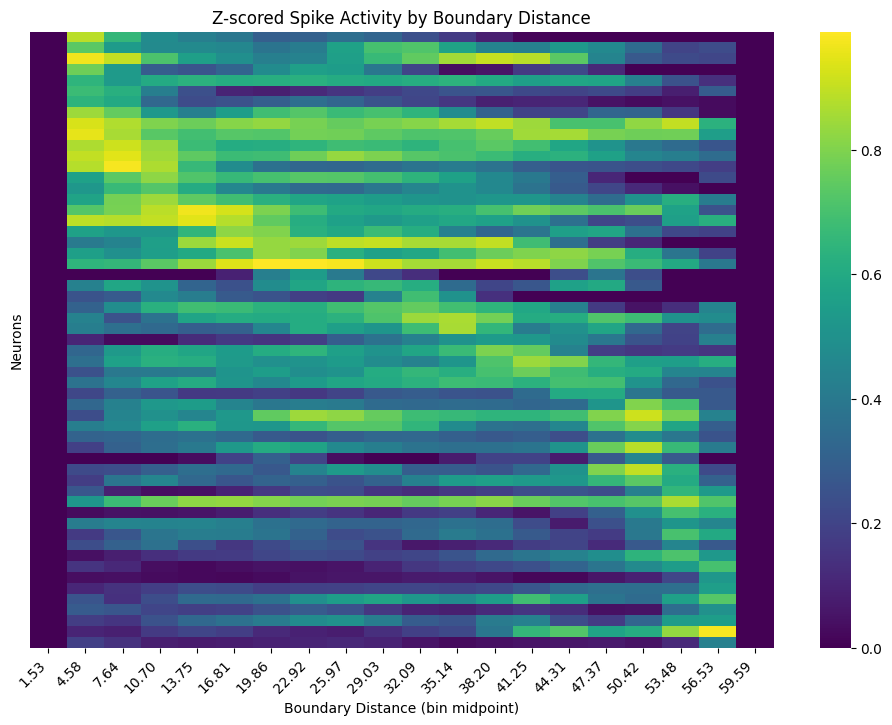

In [ ]:
#plot heatmaps
pursuit.tuning.heatmap(RSC_smoothed_sorted)
pursuit.tuning.heatmap(CA1_smoothed_sorted)
pursuit.tuning.heatmap(CA3_smoothed_sorted)

In [25]:
RSC_count = pursuit.tuning.count_neurons(RSC_cleaned)
CA1_count = pursuit.tuning.count_neurons(CA1_cleaned)
CA3_count = pursuit.tuning.count_neurons(CA3_cleaned)

In [26]:
RSC_count


({'KB10_02_pursuitRoot.mat': 2,
  'KB10_03_pursuitRoot.mat': 1,
  'KB10_08_pursuitRoot.mat': 5,
  'KB10_09_pursuitRoot.mat': 5,
  'KB10_10_pursuitRoot.mat': 8,
  'KB10_11_pursuitRoot.mat': 4,
  'KB10_13_pursuitRoot.mat': 5,
  'KB10_15_pursuitRoot.mat': 3,
  'KB10_17_pursuitRoot.mat': 8,
  'KB10_20_pursuitRoot.mat': 6,
  'KB20_02_pursuitRoot.mat': 4,
  'KB20_03_pursuitRoot.mat': 8,
  'KB20_04_pursuitRoot.mat': 5,
  'KB20_05_pursuitRoot.mat': 9,
  'KB20_06_pursuitRoot.mat': 6,
  'KB20_07_pursuitRoot.mat': 5,
  'KB20_09_pursuitRoot.mat': 10,
  'KB20_10_pursuitRoot.mat': 3,
  'KB20_11_pursuitRoot.mat': 3,
  'KB20_12_pursuitRoot.mat': 6,
  'KB20_13_pursuitRoot.mat': 3,
  'KB20_14_pursuitRoot.mat': 6,
  'KB20_15_pursuitRoot.mat': 6,
  'KB20_19_pursuitRoot.mat': 6,
  'KB20_21_pursuitRoot.mat': 6,
  'KB20_22_pursuitRoot.mat': 1,
  'KB20_24_pursuitRoot.mat': 5,
  'KB20_25_pursuitRoot.mat': 2,
  'KB20_26_pursuitRoot.mat': 4,
  'KB20_34_pursuitRoot.mat': 3,
  'KB20_35_pursuitRoot.mat': 19,
  'LP0

In [27]:
CA1_count

({'KB09_20_pursuitRoot.mat': 8,
  'KB09_22_pursuitRoot.mat': 6,
  'KB09_23_pursuitRoot.mat': 15,
  'KB09_24_pursuitRoot.mat': 7,
  'KB09_25_pursuitRoot.mat': 6,
  'KB09_26_pursuitRoot.mat': 5,
  'KB10_09_pursuitRoot.mat': 5,
  'KB10_10_pursuitRoot.mat': 8,
  'KB10_13_pursuitRoot.mat': 5,
  'KB10_15_pursuitRoot.mat': 3,
  'KB20_34_pursuitRoot.mat': 3,
  'KB20_35_pursuitRoot.mat': 19,
  'KB20_40_pursuitRoot.mat': 4,
  'KB20_41_pursuitRoot.mat': 5,
  'KB20_42_pursuitRoot.mat': 18,
  'KB20_44_pursuitRoot.mat': 16,
  'LP03_01_pursuitRoot.mat': 27,
  'LP03_03_pursuitRoot.mat': 14,
  'LP03_04_pursuitRoot.mat': 26,
  'LP03_05_pursuitRoot.mat': 19,
  'LP03_06_pursuitRoot.mat': 11,
  'LP03_07_pursuitRoot.mat': 16,
  'LP03_09_pursuitRoot.mat': 21,
  'LP03_10_pursuitRoot.mat': 18,
  'LP03_12_pursuitRoot.mat': 34,
  'LP03_13_pursuitRoot.mat': 29,
  'LP03_14_pursuitRoot.mat': 14,
  'LP03_15_pursuitRoot.mat': 12,
  'LP03_17_pursuitRoot.mat': 13,
  'LP03_18_pursuitRoot.mat': 10,
  'LP06_38_pursuitRoot

In [28]:
CA3_count

({'KB09_36_pursuitRoot.mat': 13,
  'KB09_37_pursuitRoot.mat': 13,
  'KB10_17_pursuitRoot.mat': 8,
  'KB10_19_pursuitRoot.mat': 8,
  'KB10_20_pursuitRoot.mat': 6,
  'KB10_23_pursuitRoot.mat': 5,
  'KB10_27_pursuitRoot.mat': 4},
 57)